In [336]:
import pandas as pd
import numpy as np
import re
import time

import bs4 as bs4
import json

import glob
import tqdm

pd.set_option("max.columns", 131)

#https://strftime.org/
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/kevintakano/miniconda3/lib/python3.8/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['vstack', 'hstack']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [337]:
df = pd.read_csv("raw_data.csv")
df = df[df['y'].notnull()].iloc[:,1:]
# df = df[df['y'].isin(['0','1'])]
df.shape

(307, 5)

In [338]:
df.head()

,title,upload_date,view_count,tempo_desde_pub,y
0,How to Breakdance : CC's Breakdancing Footwork,2008-10-25,735081,4721.0,1.0
1,Breakdance The Movie AKA Breakin - First Battl...,2009-06-14,658147,4489.0,0.0
2,Jakub Józef Orliński - Breakdancing & Opera | ...,2019-09-16,102757,743.0,0.0
3,free fire break dance video😜😆😆,2021-10-02,6,-4.0,0.0
4,¡Pase de Oro! El break dance extremo conquista...,2017-01-22,3134585,1710.0,0.0


In [339]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [340]:
df_limpo = pd.DataFrame(index=df.index)
df_limpo['title'] = df['title']

## 1. Limpeza da data

In [341]:

df_limpo['date'] = pd.to_datetime(df['upload_date'])

## 2. Limpeza de Views

In [342]:
df_limpo['views'] = df['view_count']

## 3. Features

In [343]:
features = pd.DataFrame(index=df_limpo.index)
y = df['y'].astype(int).copy()

In [344]:
features['tempo_desde_pub'] = (pd.to_datetime("2019-12-03") - df_limpo['date']) / np.timedelta64(1, 'D')
features['views'] = df_limpo['views']
features['views_por_dia'] = features['views'] / features['tempo_desde_pub']
features = features.drop(['tempo_desde_pub'], axis=1)

In [345]:
features.head()

,views,views_por_dia
0,735081,181.232988
1,658147,172.109571
2,102757,1317.397436
3,6,-0.008969
4,3134585,2999.602871


<AxesSubplot:>

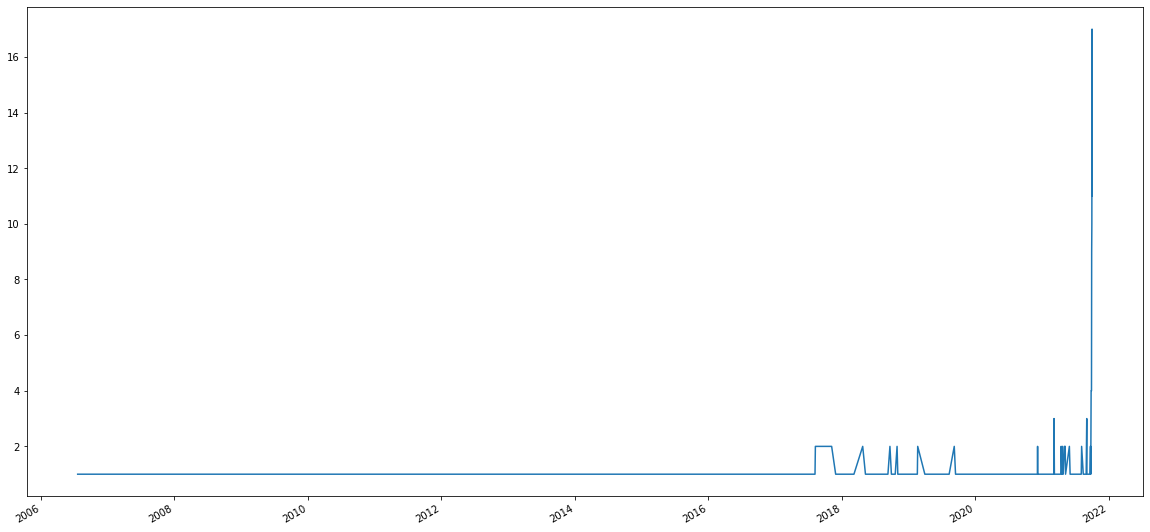

In [346]:
df_limpo.date.value_counts().plot(figsize=(20,10))

In [347]:
base = "2021-09-27"

mask_train = df_limpo['date'] < base
mask_val = df_limpo['date'] >= base

Xtrain, Xval = features[mask_train], features[mask_val]
ytrain, yval = y[mask_train], y[mask_val]
Xtrain.shape, Xval.shape, ytrain.shape, yval.shape

((248, 2), (59, 2), (248,), (59,))

In [348]:
df_limpo['title']

0         How to Breakdance : CC's Breakdancing Footwork
1      Breakdance The Movie AKA Breakin - First Battl...
2      Jakub Józef Orliński - Breakdancing & Opera | ...
3                         free fire break dance video😜😆😆
4      ¡Pase de Oro! El break dance extremo conquista...
                             ...                        
302    Breakdance Top 14 Suicide Moves 2019  || Best ...
303    Chris Brown -- The INSANE Breakdance Battle | TMZ
304                       Lazy legs Disabled breakdancer
305    ITZY “LOCO” Dance Tutorial | Chorus + Dance Br...
306                      JBL Unbreakable 2021 livestream
Name: title, Length: 307, dtype: object

In [349]:
title_train

0         How to Breakdance : CC's Breakdancing Footwork
1      Breakdance The Movie AKA Breakin - First Battl...
2      Jakub Józef Orliński - Breakdancing & Opera | ...
4      ¡Pase de Oro! El break dance extremo conquista...
6      SymphoBreaks (Awesome Energy) - Freestyle Megamix
                             ...                        
302    Breakdance Top 14 Suicide Moves 2019  || Best ...
303    Chris Brown -- The INSANE Breakdance Battle | TMZ
304                       Lazy legs Disabled breakdancer
305    ITZY “LOCO” Dance Tutorial | Chorus + Dance Br...
306                      JBL Unbreakable 2021 livestream
Name: title, Length: 248, dtype: object

In [350]:
from sklearn.feature_extraction.text import TfidfVectorizer

title_train = df_limpo[mask_train]['title']
title_val = df_limpo[mask_val]['title']

title_vec = TfidfVectorizer(min_df=2)
title_bow_train = title_vec.fit_transform(title_train)
title_bow_val = title_vec.transform(title_val)


In [351]:
title_bow_train.shape

(248, 227)

In [352]:
1 - 1277/(228*193)

0.9709799109171894

In [353]:
title_bow_train

<248x227 sparse matrix of type '<class 'numpy.float64'>'
	with 1240 stored elements in Compressed Sparse Row format>

In [354]:
from scipy.sparse import hstack, vstack

Xtrain_wtitle = hstack([Xtrain, title_bow_train])
Xval_wtitle = hstack([Xval, title_bow_val])

In [355]:
Xtrain_wtitle.shape, Xval_wtitle.shape

((248, 229), (59, 229))

In [356]:
from collections import Counter

Counter(ytrain)

Counter({1: 52, 0: 196})

In [357]:
mdl = RandomForestClassifier(n_estimators=1000, random_state=0, class_weight="balanced", n_jobs=6)
mdl.fit(Xtrain_wtitle, ytrain)

RandomForestClassifier(class_weight='balanced', n_estimators=1000, n_jobs=6,
                       random_state=0)

In [358]:
p = mdl.predict_proba(Xval_wtitle)[:, 1]

In [359]:
from sklearn.metrics import roc_auc_score, average_precision_score

In [360]:
average_precision_score(yval, p)

0.484250700280112

In [361]:
roc_auc_score(yval, p)

0.8244897959183674

# 5 Active learning

70 exemplos que o modelo tenha dificuldade
30 exemplos aleatoriamente

In [306]:
df_unlabeled = pd.read_csv("raw_data.csv", index_col=0)
df_unlabeled = df_unlabeled[df_unlabeled['y'].isnull()].dropna(how='all')
df_unlabeled.shape

(1312, 5)

In [307]:
df_unlabeled.head(5)

,title,upload_date,view_count,tempo_desde_pub,y
307,Break Machine - Street Dance (1984),2017-08-20,1922846,1500.0,NaN
308,Jose vs. Victor // BREAK FREE DAY 2021 // BBOY...,2021-07-19,13790,71.0,NaN
309,Green Hell - la colonie de vacances foireuse a...,2021-06-10,358905,110.0,NaN
310,How to Top Rock | Break Dancing,2013-05-16,157408,3057.0,NaN
311,Breakdancing & More Wins VS. Fails | People Ar...,2021-06-27,60021,93.0,NaN


In [308]:
df_limpo_u = pd.DataFrame(index=df_unlabeled.index)
df_limpo_u['title'] = df_unlabeled['title']

In [309]:

df_limpo_u['date'] = pd.to_datetime(df_unlabeled['upload_date'])

In [310]:
df_limpo_u['views'] = df_unlabeled['view_count']

In [311]:
df_limpo_u.value_counts()

title                                                                                    date        views  
Amazing Moments at BATTLE OF THE YEAR 2019 // .stance                                    2019-11-01  987863     3
Mobb Deep - Burn Remix | BBoy Breakdance Music 4 Life 2015                               2015-04-26  2360996    3
【 BREAK DANCE 】Power move Collection ( Bboy SNACK , ARIYA , GOODmen , FreeasyClothing )  2018-05-30  1968848    3
【 BreakDance 】Easy Level Beginner skills                                                 2021-03-08  421513     3
Red Bull BC One 2015 The Soundtrack | Bboy Breakdance Music                              2015-01-01  2969563    3
                                                                                                               ..
Break Machine - Street Dance (1984)                                                      2017-08-20  1922846    1
                                                                                             

In [312]:
features_u = pd.DataFrame(index=df_limpo_u.index)

In [313]:
features_u['tempo_desde_pub'] = (pd.to_datetime("2019-12-03") - pd.to_datetime(df_limpo_u['date'])) / np.timedelta64(1, 'D')
features_u['views'] = df_limpo_u['views']
features_u['views_por_dia'] = features_u['views'] / features_u['tempo_desde_pub']
features_u = features_u.drop(['tempo_desde_pub'], axis=1)

In [314]:
r = features_u.index[np.isinf(features_u).any(1)]
r

Int64Index([908, 1416], dtype='int64')

In [315]:
df_limpo_u = df_limpo_u[~df_limpo_u.index.isin(r)]

In [316]:
df_unlabeled = df_unlabeled[~df_unlabeled.index.isin(r)]

In [317]:
features_u = features_u[~features_u.index.isin(r)]
features_u.shape

(1310, 2)

In [318]:
from sklearn.feature_extraction.text import TfidfVectorizer

title_u = df_limpo_u['title']
title_bow_u = title_vec.transform(title_u)


In [319]:
title_bow_u

<1310x227 sparse matrix of type '<class 'numpy.float64'>'
	with 5622 stored elements in Compressed Sparse Row format>

In [320]:
Xu_wtitle = hstack([features_u, title_bow_u])

In [321]:
pu = mdl.predict_proba(Xu_wtitle)[:, 1]

In [322]:
df_unlabeled['p'] = pu

In [323]:
df_unlabeled.head(1)

,title,upload_date,view_count,tempo_desde_pub,y,p
307,Break Machine - Street Dance (1984),2017-08-20,1922846,1500.0,NaN,0.012


In [324]:
mask_u = (df_unlabeled['p'] >= 0.40) & (df_unlabeled['p'] <= 0.6)
mask_u.sum()

182

In [325]:
mask_u

307     False
308     False
309     False
310     False
311     False
        ...  
1615    False
1616    False
1617     True
1618    False
1619    False
Name: p, Length: 1310, dtype: bool

In [326]:
df_unlabeled[mask_u]#.sort_values("p")

,title,upload_date,view_count,tempo_desde_pub,y,p
318,Mindset /w Killa Keim (From DownTown) | BBOY.O...,2021-03-11,4728,201.0,NaN,0.463
319,BBOY ZOOPREME | MUSIC IN HIS SOUL 🎶,2021-09-22,1356,6.0,NaN,0.498
323,BBOY ZOOTY ZOOT | AMAZING FLOW 🌊,2021-09-14,2902,14.0,NaN,0.495
326,Bboy music 2021- run it,2021-10-02,43,-4.0,NaN,0.409
327,Red Bull BC One B-Boy Cypher Japan 2021 | LIVE...,2021-09-26,50041,2.0,NaN,0.497
...,...,...,...,...,...,...
1601,BBOY POCKET NEXT LEVEL 2019,2019-02-03,309515,968.0,NaN,0.444
1603,BC One Squad vs Keep Your Dreams [top 8] // st...,2021-09-28,6471,0.0,NaN,0.471
1606,BBOY ROXRITE Recap @SECRET BATTLE Red Bull BC ...,2021-03-22,125,190.0,NaN,0.473
1609,BBOY LILOU & BBOY MENNO Recap | Red Bull Dance...,2021-06-25,881,95.0,NaN,0.549


In [327]:
dificeis = df_unlabeled[mask_u]

In [328]:
aleatorios = df_unlabeled[~mask_u].sample(60, random_state=0)

In [332]:
c = pd.concat([dificeis, aleatorios])
c.to_csv("active_label1.csv")
c.shape

(242, 6)

In [335]:
c = c[c['y'].notnull()]
c

,title,upload_date,view_count,tempo_desde_pub,y,p


In [331]:
aleatorios.head()

,title,upload_date,view_count,tempo_desde_pub,y,p
1330,History of Breakdancing,2015-12-16,1358,2113.0,NaN,0.015
810,nyoni & bota performing break dance #shorts #y...,2021-10-02,2,-4.0,NaN,0.013
1057,Lussy Sky vs Lil G | 3rd Place | Bboy | 2019 W...,2019-06-23,41059,828.0,NaN,0.227
1411,BBOY NOODLE | Bomb Jam 2021,2021-05-17,738,134.0,NaN,0.721
820,TOP 10 BBOY Sets VOL6 (BreakDance Compilation ...,2021-01-22,27583,249.0,NaN,0.231
